In [1]:
import os
import torch
import pickle

from MeLU import MeLU
from options import config
from model_training import training
from data_generation import generate
from evidence_candidate import selection
from tqdm import tqdm


if __name__ == "__main__":
    master_path= "./ml"
    if not os.path.exists("{}/".format(master_path)):
        os.mkdir("{}/".format(master_path))
        # preparing dataset. It needs about 22GB of your hard disk space.
        generate(master_path)

    # training model.
    melu = MeLU(config)
    state = "warm_state"
    model_filename = "{}/models_{}.pkl".format(master_path,state)
    if not os.path.exists(model_filename):
        # Load training dataset.
        training_set_size = int(len(os.listdir("{}/{}".format(master_path,state))) / 4)
        supp_xs_s = []
        supp_ys_s = []
        query_xs_s = []
        query_ys_s = []
        for idx in tqdm(range(training_set_size)):
            supp_xs_s.append(pickle.load(open("{}/{}/supp_x_{}.pkl".format(master_path,state, idx), "rb")))
            supp_ys_s.append(pickle.load(open("{}/{}/supp_y_{}.pkl".format(master_path, state, idx), "rb")))
            query_xs_s.append(pickle.load(open("{}/{}/query_x_{}.pkl".format(master_path, state, idx), "rb")))
            query_ys_s.append(pickle.load(open("{}/{}/query_y_{}.pkl".format(master_path, state, idx), "rb")))
        total_dataset = list(zip(supp_xs_s, supp_ys_s, query_xs_s, query_ys_s))
        del(supp_xs_s, supp_ys_s, query_xs_s, query_ys_s)
        history = training(melu, total_dataset, batch_size=config['batch_size'], num_epoch=config['num_epoch'], model_save=True, model_filename=model_filename)
    else:
        trained_state_dict = torch.load(model_filename)
        melu.load_state_dict(trained_state_dict)



C:\Users\rnautiyal2\Anaconda3\envs\charanfyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 20/20 [05:24<00:00, 16.22s/it]


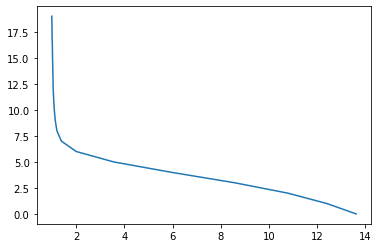

In [4]:
import matplotlib.pyplot as plt
y = list(range(0,20))
plt.plot(history,y)

In [5]:
state = "warm_state"
# model_filename = "{}/models_{}.pkl".format(master_path,state)
# if not os.path.exists(model_filename):
# Load training dataset.
testing_set_size = int(len(os.listdir("{}/{}".format('testing',state))) / 4)
supp_xs_s = []
supp_ys_s = []
query_xs_s = []
query_ys_s = []
for idx in tqdm(range(testing_set_size)):
    supp_xs_s.append(pickle.load(open("{}/{}/supp_x_{}.pkl".format('testing',state, idx), "rb")))
    supp_ys_s.append(pickle.load(open("{}/{}/supp_y_{}.pkl".format('testing', state, idx), "rb")))
    query_xs_s.append(pickle.load(open("{}/{}/query_x_{}.pkl".format('testing', state, idx), "rb")))
    query_ys_s.append(pickle.load(open("{}/{}/query_y_{}.pkl".format('testing', state, idx), "rb")))

100%|██████████| 260/260 [00:00<00:00, 322.97it/s]


In [ ]:
melu.model().to()

In [21]:
from torch.nn import functional as F
trained_state_dict = torch.load(model_filename)
melu.load_state_dict(trained_state_dict)

final_loss = []
for i in range(len(supp_xs_s)):
    prediction = melu.model(supp_xs_s[i].cuda())
    temp_loss = F.mse_loss(prediction, supp_ys_s[i].cuda().view(-1, 1))
    final_loss.append(temp_loss.item())

for j in range(len(query_xs_s)):
    prediction = melu.model(query_xs_s[j].cuda())
    temp_loss = F.mse_loss(prediction, query_ys_s[j].cuda().view(-1, 1))
    final_loss.append(temp_loss.item())

In [22]:
import numpy as np
np.mean(final_loss)

1.034084714934803

In [13]:
supp_ys_s[0]

tensor([3., 5., 3., 3., 3., 4., 4., 4., 5., 4.])

In [3]:
pip install matplotlib

  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:

# selecting evidence candidates.
# evidence_candidate_list = selection(melu, master_path, config['num_candidate'])
# for movie, score in evidence_candidate_list:
#     print(movie, score)